In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, time
import sys
import matplotlib
from EnKF import EnKF
from SIR import SIR
from OTF import OTF

# Configure matplotlib to embed fonts in PDF/PS outputs and set default font sizes.
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('font', size=16)

# Set a fixed random seed for reproducibility.
# np.random.seed(0)

In [2]:

def A(x,t=0):
    try:
        return F @ x
    except:
        return torch.from_numpy(F).to(torch.float32) @ x

# Choose h(x) here, the observation rule
def h(x):
    return x[0,None]*x[0,None]
    # return x[0].reshape(1,-1)*x[0].reshape(1,-1)    
    # return x*x

def Gen_True_Data(L, dy, T, sigma0, sigma, gamma, tau):
    """
    Generates true state and observation data using the Linear-Quadratic model.
    
    For a given number of time steps, the true state is evolved by the
    Linear model. The observations are generated using an observation rule
    (function h) with added Gaussian noise.
    
    Parameters
    ----------
    L : int
        Dimension of the state space.
    dy : int
        Dimension of the observation space.
    T : int
        Number of time steps.
    sigma0 : float
        Standard deviation for the initial state distribution.
    sigma : float
        Standard deviation for the process noise.
    gamma : float
        Standard deviation for the observation noise.
    tau : float
        Time step size.
    
    Returns
    -------
    x : ndarray
        True state evolution with shape (T x L x 1).
    y : ndarray
        Observations with shape (T x dy x 1).
    """
    # Initialize arrays for state and observation data.
    x = np.zeros((T, L, 1))
    y = np.zeros((T, dy, 1))
    
    # Set initial state with added noise from a multivariate normal distribution.
    x[0,] = np.random.multivariate_normal(np.zeros(L), sigma0 * sigma0 * np.eye(L), 1).T

    for i in range(T - 1):
        # Propagate the state using the Linear dynamics.
        x[i + 1, :] =  A(x[i, :]) + np.random.multivariate_normal(np.zeros(L),sigma*sigma * np.eye(L),1).T
        # Generate the observation by applying the observation function h and adding noise.
        y[i + 1, :] = h(x[i + 1, :]) + np.random.multivariate_normal(np.zeros(dy), gamma * gamma * np.eye(dy), 1).T
    
    return x, y

In [3]:
# Simulation parameters.
n = 1 
L = n*2 # number of states
tau = 1e-1 # timpe step 
T = int(5/tau) # number of time steps T = 5 s
dy = L # number of states observed
t = np.arange(0.0, tau * T, tau)  # Time vector.

# dynmaical system
# H = np.array([[1,0]]) 
H = np.eye(1,dy)
alpha = 0.9
a = alpha 
b = np.sqrt(1-alpha**2)
# c = alpha

F = np.array([[a, -b],[b,a]]) 

F = np.kron(np.eye(int(n)), F)
# F = np.eye(2*n)*0.9

noise = np.sqrt(1e-2) # noise level std
sigma = noise # Noise in the hidden state
sigma0 = 1#5*noise # Noise in the initial state distribution
gamma = noise # Noise in the observation
x0_amp = 1#/noise # Amplifiying the initial state 
Noise = [sigma, gamma]

N = int(1e3)  # Number of ensemble particles.
NUM_SIM = 1        # Number of independent simulations.

# Define hyperparameters for the optimal transport networks.
parameters = {
    'normalization': 'None',   # Options: 'None', 'Standard', 'MinMax'
    'INPUT_DIM': [L, dy], 
    'NUM_NEURON': int(64 / 2),  # Number of neurons in the hidden layers.
    'BATCH_SIZE': int(64 / 2),  # Batch size for training.
    'LearningRate': [1e-4 , 1e-4],  # Learning rates for the mapping networks.
    'ITERATION': int(1024*1),
    'Final_Number_ITERATION': int(64 /2),
    'K_in': 10,  # Number of inner iterations for the transport map optimization.
    'num_resblocks': [1, 2]  # Number of residual blocks for the two networks (f,T).
}

In [4]:
# Containers for true states, observations, and initial particles.
X_True = np.zeros((NUM_SIM, T, L, 1))
Y_True = np.zeros((NUM_SIM, T, dy, 1))
X0 = np.zeros((NUM_SIM, L, N))

# Generate true state trajectories, observations, and initial particles for each simulation.
for k in range(NUM_SIM):
    X_True[k,], Y_True[k,] = Gen_True_Data(L, dy, T, sigma0, sigma, gamma, tau)
    X0[k,] = np.random.multivariate_normal(np.zeros(L), sigma0 * sigma0 * np.eye(L), N).T

In [5]:
# Apply filtering methods using the true observations and initial particles.
# The expected data structure is: (NUM_SIM x T x L x N)
X_EnKF = EnKF(Y_True, X0, A, h, t, Noise, SIGMA=1e-6)
X_SIR = SIR(Y_True, X0, A, h, t, Noise)
X_OTF = OTF(Y_True, X0, A, h, t, Noise, parameters)

--- EnKF running time : 0.009773015975952148 seconds ---
--- SIR time : 0.011053085327148438 seconds ---
Simu#1/1, Time Step:1/49, Iteration: 1024/1024, loss = 0.1505
Simu#1/1, Time Step:2/49, Iteration: 512/512, loss = 0.1967
Simu#1/1, Time Step:3/49, Iteration: 256/256, loss = 0.2960
Simu#1/1, Time Step:4/49, Iteration: 128/128, loss = 0.2326
Simu#1/1, Time Step:5/49, Iteration: 64/64, loss = 0.1549
Simu#1/1, Time Step:6/49, Iteration: 32/32, loss = 0.0375
Simu#1/1, Time Step:7/49, Iteration: 32/32, loss = 0.1386
Simu#1/1, Time Step:8/49, Iteration: 32/32, loss = 0.1678
Simu#1/1, Time Step:9/49, Iteration: 32/32, loss = -0.0759
Simu#1/1, Time Step:10/49, Iteration: 32/32, loss = -0.1110
Simu#1/1, Time Step:11/49, Iteration: 32/32, loss = 0.0338
Simu#1/1, Time Step:12/49, Iteration: 32/32, loss = -0.0176
Simu#1/1, Time Step:13/49, Iteration: 32/32, loss = -0.0082
Simu#1/1, Time Step:14/49, Iteration: 32/32, loss = 0.0331
Simu#1/1, Time Step:15/49, Iteration: 32/32, loss = 0.0080
Simu#

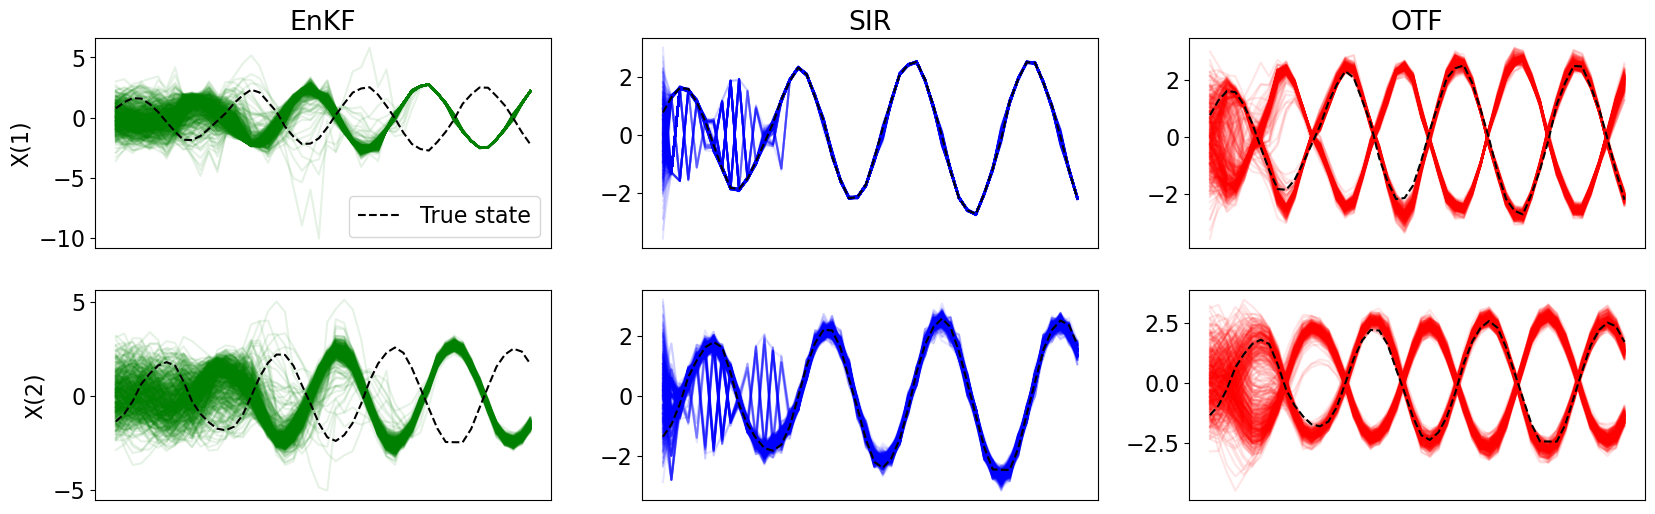

In [6]:
# Plot the results for each filtering method alongside the true state.
plot_particle = 500
plt.figure(figsize=(20, int(3*L)))
for l in range(L):
    # Plot EnKF results.
    plt.subplot(L, 3, 3 * l + 1)
    plt.plot(t, X_EnKF[k, :, l, :plot_particle], 'g', alpha=0.1)
    plt.plot(t, X_True[k, :, l], 'k--', label='True state')
    plt.xlabel('Time')
    if l == 0:
        plt.title('EnKF')
        plt.legend()
    plt.ylabel(f'X({l + 1})')
    if l <= 1:
        plt.gca().get_xaxis().set_visible(False)

for l in range(L):
    # Plot SIR results.
    plt.subplot(L, 3, 3 * l + 2)
    plt.plot(t, X_SIR[k, :, l, :plot_particle], 'b', alpha=0.1)
    plt.plot(t, X_True[k, :, l], 'k--', label='True state')
    plt.xlabel('Time')
    if l == 0:
        plt.title('SIR')
    if l <= 1:
        plt.gca().get_xaxis().set_visible(False)

for l in range(L):
    # Plot OTF results.
    plt.subplot(L, 3, 3 * l + 3)
    plt.plot(t, X_OTF[k, :, l, :plot_particle], 'r', alpha=0.1)
    plt.plot(t, X_True[k, :, l], 'k--', label='True state')
    plt.xlabel('Time')
    if l == 0:
        plt.title('OTF')
    if l <= 1:
        plt.gca().get_xaxis().set_visible(False)

# Optionally, you can display the plots by calling plt.show() here.
plt.show()